In [1]:

import datetime
import time

import random
import math
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm_notebook as tqdm 

import os, shutil
from zipfile import ZipFile

import skimage
from skimage.io import imread,imsave
from skimage import morphology
from skimage.filters import threshold_otsu
from skimage import img_as_uint


from digest_patchExtractor import DualPatchExtractor
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from models_pytorch import DualEncoding_U_Net,init_weights,save_model,load_model
from DigestPath_Dataset import DataSet,ToTensor,Scale,Color

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import pandas as pd 

# from preprocess import fuse_roi,generate_train_mask
# from prediction import whole_img_pred,post_process

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
map1_dir_train='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_1_train/'
map2_dir_train='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_2_train/'
mask_dir_train='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/mask_train/'
map1_patch_dir_train='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_1_patches_train/'
map2_patch_dir_train='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_2_patches_train/'
mask_patch_dir_train='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/mask_patches_train/'

map1_dir_test='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_1_test/'
map2_dir_test='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_2_test/'
mask_dir_test='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/mask_test/'
map1_patch_dir_test='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_1_patches_test/'
map2_patch_dir_test='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/map_2_patches_test/'
mask_patch_dir_test='/home/vahadaneabhi01/datalab/training-assets/R_medical/atheeth/digest_new/colon_repo/digest_path/mask_patches_test/'

dir_list=[map1_dir_train,map2_dir_train,mask_dir_train,map1_patch_dir_train,\
          map2_patch_dir_train,mask_patch_dir_train,map1_dir_test,map2_dir_test,\
          mask_dir_test,map1_patch_dir_test,map2_patch_dir_test,mask_patch_dir_test]
# for directory in dir_list:
#     if not os.path.exists(directory):
#         os.system("mkdir {}".format(directory))
#         print('made directory')

In [3]:

map_1_dir='map_1_gray_matlab'
map_2_dir='map_2_gray_matlab'
mask_dir='tissue-train-pos-v1_mask'

all_img_list=os.listdir(map_1_dir)

train_list=random.sample(all_img_list, 150)
test_list=list(set(all_img_list)-set(train_list))
# for train_img in tqdm(train_list):
#     mask_img_name=train_img.split('.')[0]+'_mask.jpg'
#     shutil.copy(os.path.join(map_1_dir,train_img),os.path.join(map1_dir_train,train_img))
#     shutil.copy(os.path.join(map_2_dir,train_img),os.path.join(map2_dir_train,train_img))
#     shutil.copy(os.path.join(mask_dir,mask_img_name),os.path.join(mask_dir_train,mask_img_name))
    
# for test_img in tqdm(test_list):
#     test_mask_img_name=test_img.split('.')[0]+'_mask.jpg'
#     shutil.copy(os.path.join(map_1_dir,test_img),os.path.join(map1_dir_test,test_img))
#     shutil.copy(os.path.join(map_2_dir,test_img),os.path.join(map2_dir_test,test_img))
#     shutil.copy(os.path.join(mask_dir,test_mask_img_name),os.path.join(mask_dir_test,test_mask_img_name))

In [4]:

# train_extractor=DualPatchExtractor(map1_dir_train,map2_dir_train,mask_dir_train,map1_patch_dir_train,map2_patch_dir_train\
#                                ,mask_patch_dir_train,overlap=False,progress_bar=True)

# train_extractor.extract_patches()

# test_extractor=DualPatchExtractor(map1_dir_test,map2_dir_test,mask_dir_test,map1_patch_dir_test,map2_patch_dir_test\
#                                ,mask_patch_dir_test,overlap=False,progress_bar=True)

# test_extractor.extract_patches()

In [5]:
batch_size_train=4
batch_size_test=4
transform=torchvision.transforms.Compose([Scale(),ToTensor()])    



train_dataset=DataSet(map1_patch_dir_train,map2_patch_dir_train,mask_patch_dir_train,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,num_workers=0,shuffle=True)
print(train_dataset.__len__()," Train samples")

test_dataset=DataSet(map1_patch_dir_test,map2_patch_dir_test,mask_patch_dir_test,transform=transform)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,num_workers=0,shuffle=False)
print(test_dataset.__len__()," Test samples")


6797  Train samples
1416  Test samples


In [6]:
    
def dice_metric(y_pred,y_true):
    smooth = 1e-16
    num = y_true.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_true.view(num, -1)
    
        
    intersection = (m1* m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
        
    return score
    

1.0 1.0 1.0
(512, 512) 1.0


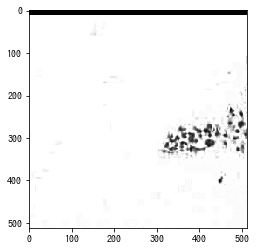

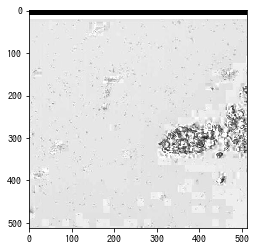

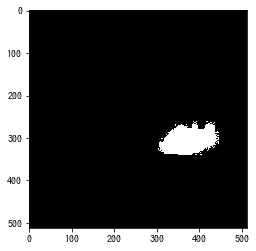

In [7]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def visualize_loader(loader,index):
    for i,sample in enumerate(loader):
        #print(sample['image'].shape)
        if i==1:
            map1=(sample['map1'][index]).numpy()
            
            
            #image=np.zeros(image_i.shape,dtype=np.uint8)
            #image[np.where(image_i!=0)]=255

            map2=(sample['map2'][index]).numpy()
            
            
        
            mask=(sample['mask'][index]).numpy()
            print(np.amax(map1),np.amax(mask),np.amax(map2))
            
            map1_batch, map2_batch,mask_batch = sample['map1'].to(device, dtype = torch.float)\
                ,sample['map2'].to(device, dtype = torch.float),sample['mask'].to(device,dtype=torch.float)
            
            img_tensor=torch.cat((map1_batch.detach().cpu(),map2_batch.detach().cpu()\
                                          ,mask_batch.detach().cpu()),axis=0)
            img_grid = torchvision.utils.make_grid(img_tensor,nrow=4,padding=10)
            
            torchvision.utils.save_image(img_grid,'sample.png')
        
           
    
            map1=np.squeeze(map1.transpose(1,2,0),axis=2)
            map2=np.squeeze(map2.transpose(1,2,0),axis=2)
            mask=np.squeeze(mask.transpose(1,2,0),axis=2)
            print(map1.shape,np.amax(map1))
        
            fig=plt.figure()
            plt.imshow(map1,cmap='gray')
            fig2=plt.figure()
            plt.imshow(map2,cmap='gray')
            fig3=plt.figure()
            plt.imshow(mask,cmap='gray')
            
            break
visualize_loader(test_loader,1)

In [8]:
model=DualEncoding_U_Net(img_ch=1,output_ch=1)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('model_{} dir has been made'.format(model_start_date))
print("Model's state_dict:")
writer = SummaryWriter('model_{}/experiment_{}'.format(model_start_date,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


# writer.close()

Model's state_dict:


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Conv1_encoding_1.conv.0.weight 	 torch.Size([64, 1, 3, 3])
Conv1_encoding_1.conv.0.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.weight 	 torch.Size([64])
Conv1_encoding_1.conv.1.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1_encoding_1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1_encoding_1.conv.3.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.weight 	 torch.Size([64])
Conv1_encoding_1.conv.4.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2_encoding_1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2_encoding_1.conv.0.bias 	 torch.Size([128])
Conv2_encoding_1.conv.1.weight 	 torch.Size([128])
Conv2_encoding_1.conv.1.bias 	 torch.Size([128])
Conv2_encoding_1.conv.1.running_mea

In [ ]:

optimizer_selected='adam'
batchsize=4
no_steps=train_dataset.__len__()//batchsize
restart_epochs=5
num_epochs=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device=="cuda:0":
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)
if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-02, betas=(0.9, 0.98))#,weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)

scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)


best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                map1_batch, map2_batch,mask_batch = sample_batched['map1'],\
                sample_batched['map2'],sample_batched['mask']
                
                map1_batch, map2_batch,mask_batch = map1_batch.to(device, dtype = torch.float)\
                ,map2_batch.to(device, dtype = torch.float),mask_batch.to(device,dtype=torch.float)

                # forward + backward + optimize
                outputs = torch.sigmoid(model(map1_batch,map2_batch))
                
                loss = criterion(outputs, mask_batch)
                dice_score=dice_metric(outputs,mask_batch)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if i%100==99:
                    
                
                    
                    img_tensor=torch.cat((map1_batch.detach().cpu(),outputs.detach().cpu()\
                                          ,mask_batch.detach().cpu()),axis=0)
                    
                    
            
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=100)
                    torchvision.utils.save_image(img_grid2,os.path.join(BEST_MODEL_PATH,\
                                                                        'train_iter_{}.png'\
                                                                        .format(epoch*len(train_loader)+i+1)))
                    writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):

                test_map1_batch, test_map2_batch,test_mask_batch = test_sample['map1']\
                , test_sample['map2'],test_sample['mask']
                
                test_map1_batch, test_map2_batch,test_mask_batch = test_map1_batch.to(device, dtype = torch.float),\
                test_map2_batch.to(device, dtype = torch.float),test_mask_batch.to(device, dtype = torch.float)
                test_outputs = torch.sigmoid(model(test_map1_batch,test_map2_batch))
                
                test_loss = criterion(test_outputs, test_mask_batch)
                #final_test_loss+=test_loss.detach().item()
                test_dice=dice_metric(test_outputs,test_mask_batch)
                #final_test_dice+=test_dice
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
               
                if j%100==99:
                    
                    img_tensor_test=torch.cat((test_map1_batch.detach().cpu(),\
                                               test_outputs.detach().cpu(),test_mask_batch.detach().cpu()),axis=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image(img_grid,os.path.join(BEST_MODEL_PATH,\
                                                                        'test_iter_{}.png'\
                                                                        .format(epoch*len(test_loader)+j+1)))
                    writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+'/model_optim.pth',scheduler=None)
                
                print("saved model with test dice score: {}".format(best_val))

        
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer,BEST_MODEL_PATH+'/model_final.pth',scheduler=None)

print('Finished Training')

Learning Rate : 0.01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test_loss: 0.32711617901428264
test_dice :0.562919512007374
saved model with test dice score: 0.562919512007374
Learning Rate : 0.0034496402323911


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
!nvidia-smi